# Comparison notebook: Matlab Grabow model vs Cantera Grabow Model

In [1]:
import pandas as pd
import numpy as np
import time
import cantera as ct
from matplotlib import pyplot as plt
import csv
import math
import os
import sys
from IPython.display import Image

import itertools
import logging
from collections import defaultdict

print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


### Thermo equation conversion (shomate 8 from matlab to shomate 7 in cantera)

#### Matlab: shomate 8

Source: NIST.  (2008). Water.  Retrieved  March  13,  2011,  from  NISTChemistry  Web  Book: 
http://webbook.nist.gov/cgi/cbook.cgi? ID=C7732185&Units=SI&Mask=1#Thermo-Gas

accessed from https://studylib.net/doc/9453117/shomate-equation

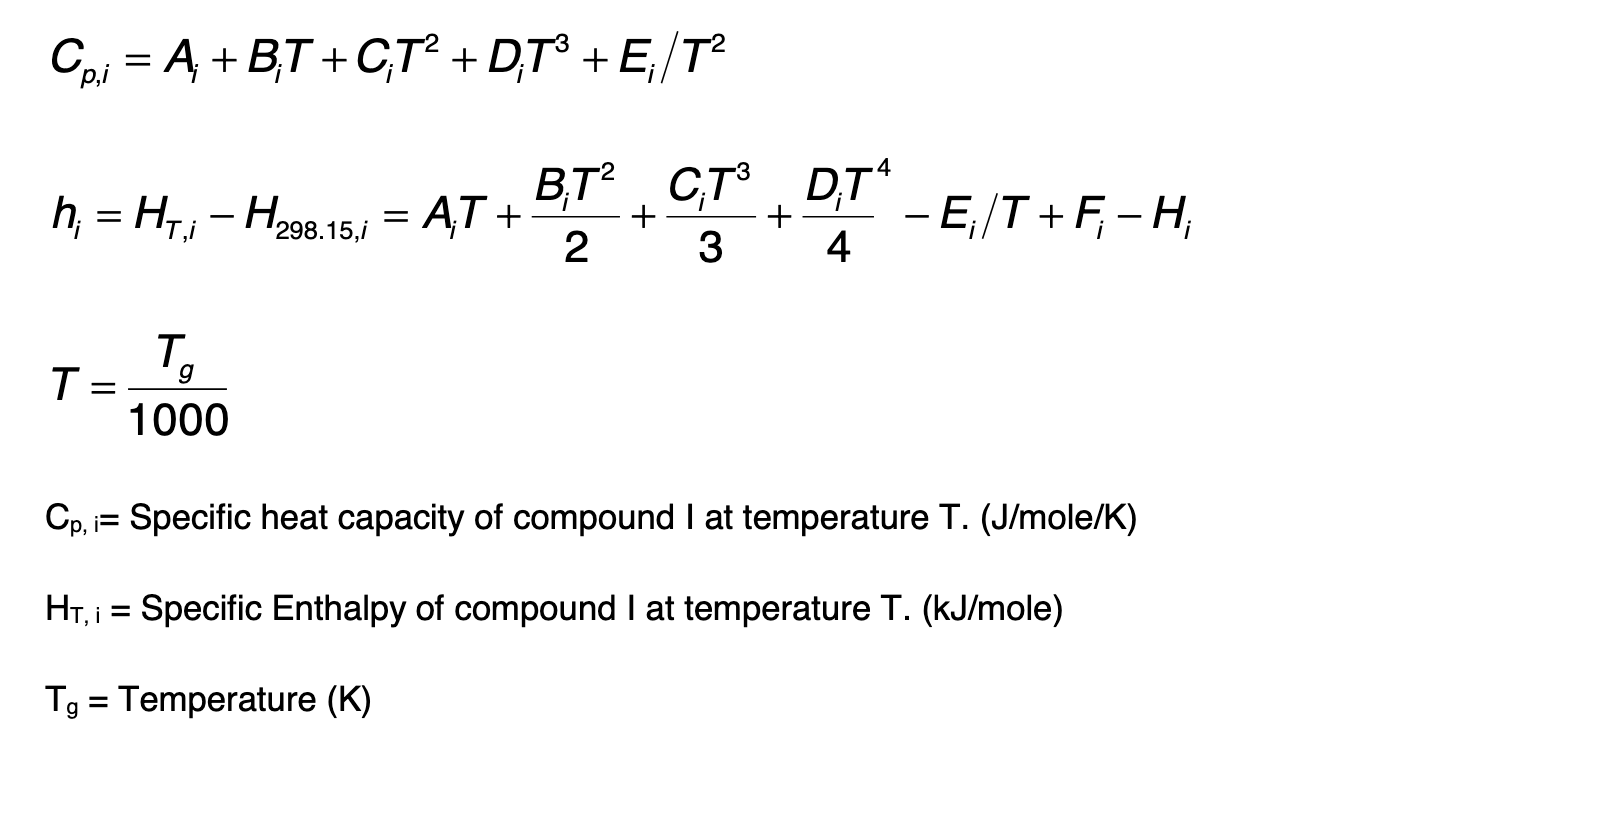

In [2]:
Image(filename='images/Shomate_8.png',width = 700, height = 300) 

#### Cantera: Shomate 7
source: cantera documentation https://cantera.org/science/science-species.html

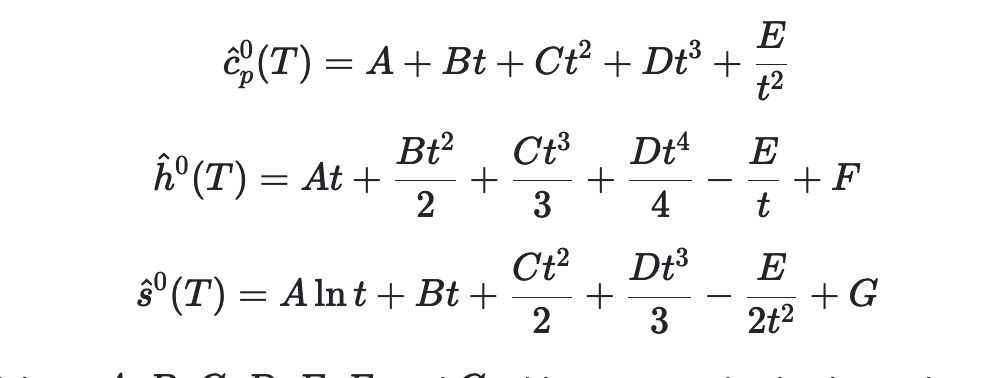

In [2]:
Image(filename='images/Shomate_7.png',width = 700, height = 300) 

### Load Grabow model .cti file into cantera

In [2]:
# Grabow model and RMG input files
cti_file_rmg = 'mech_grabow.cti'
# cti_file_rmg = 'mech_grabow.cti'

#constants
pi = math.pi

# set initial temps, pressures, concentrations
# temp = 230+273.15 # kelvin
temp = 483.5                # kelvin
pressure = 15.01*ct.one_atm # Pascals
volume_flow = 7             # [m^3/s]
X_co = 0.0650
X_co2= 0.2610
X_h2 = 0.6740
mw_co = 28.01e-3  # [kg/mol]
mw_co2 = 44.01e-3 # [kg/mol]
mw_h2 = 1.01e-3 # [kg/mol]

# CO/CO2/H2/H2O: typical is 
concentrations_rmg = {'CO': X_co,'CO2': X_co2, 'H2':X_h2}

# initialize cantera gas and surface
gas= ct.Solution(cti_file_rmg,'gas')

# surf_grab = ct.Interface(cti_file,'surface1_grab', [gas_grab])
surf = ct.Interface(cti_file_rmg,'surface1', [gas])

# gas_grab.TPX = 
gas.TPX = temp, pressure, concentrations_rmg
surf.TP = temp, pressure
surf.coverages = 'X:1.0'

# create gas inlet
inlet = ct.Reservoir(gas)

#create gas outlet
exhaust = ct.Reservoir(gas)

# Reactor volume
rradius = 35e-3
rlength = 70e-3
rvol = (rradius**2)*pi*rlength

# Catalyst Surface Area
site_density = surf.site_density*1000                #[mol/m^2]cantera uses kmol/m^2, convert to mol/m^2
cat_weight = 4.24e-3                                 #[kg]
cat_site_per_wt = (300*1e-6)*1000                    #[mol/kg] 1e-6mol/micromole, 1000g/kg
print(cat_site_per_wt)
cat_area = site_density/(cat_weight*cat_site_per_wt) #[m^3]

# reactor initialization
r = ct.IdealGasReactor(gas, energy='on')
rsurf = ct.ReactorSurface(surf, r, A=cat_area)
r.volume = rvol

# flow controllers (Graaf measured flow at 293.15 and 1 atm)
molar_flow = volume_flow*pressure/(8.3145*temp)               # [mol/s]
mass_flow = molar_flow*(X_co*mw_co+X_co2*mw_co2) # [kg/s]
mfc = ct.MassFlowController(inlet, r, mdot=mass_flow)

# initialize reactor network
sim = ct.ReactorNet([r])
# set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-10
sim.atol = 1.0e-22

#for debugging
sim.verbose = True
sim.reinitialize()

0.3
Initializing reactor network.
Reactor 0: 34 variables.
              0 sensitivity params.
Number of equations: 34
Maximum time step:                0


## Rate constant Units
### Cantera Sticking Coefficient equation

Sticking coefficient equations
### $\gamma = a T^b e^{-c/RT}$

### $k_{f}= \frac{\gamma}{\Gamma_{tot}^{m}} \sqrt{ \frac{RT}{2 \pi W} }$  ###

### Grabow "Sticking Coefficient" equation: ###

matlab equation: 
(path improved_paper_version/Graaf_final/condition_reaction.m, line 57)  
reaction(r).kfwd = reaction(r).stickcoeff * 1.0123E6 *((2*pi*mass*mamu*1000*kB*10^7*condition(cdtst).T)^(-0.5))*1E-15;

### $k_{fwd} = 1.0123\times 10^6 \frac{1}{\sqrt{2 \times \pi \times M_{molecule} \times m_{proton/neutron} \times 1000 \times k_{B} \times 10^7 \times T}} \times 10^{-15}$ ###


### $[k_{fwd}] = \frac{moles}{site \times s}$ ###


$ M_{molecule} $ = Molecular weight [amu]  
$ m_{proton/neutron} $ = mass of a proton/neutron [kg/amu]  
$ T $ = temperature in K  
$k_{B} $ = boltzmann constant  

#### Constants:   
$ m_{proton/neutron} $ = 1.66053886E-27   kg 

R = 8.314; kJ/mol/K  

$N_a$ = 6.0221415E23;  atoms/mol  

$k_B $= 1.3806503E-23 ;  J/K  

h = 6.626068E-34;    J  

mamu = $ m_{proton/neutron} $ = 1.66053886E-27 ;  kg  mass of proton or neutron

eV2kJ = 96.485;  

eV2J = eV2kJ*1E3;  

atm2bar = 1.01325;  

atm2Pa = atm2bar*1E5;  

torr2atm = 1.3158E-3;  

#### Collision rate for surface reactions
below is the upper limit (?) for the collision rate for surface reactions.  

source: Steinfeld, J. I., Francisco, J. S., Hase, W. L., & Hase, W. L. (1999). Chemical Kinetics and Dynamics. Prentice Hall. ch. 12,  pp 410-411.  https://books.google.com/books?id=I1jwAAAAMAAJ 

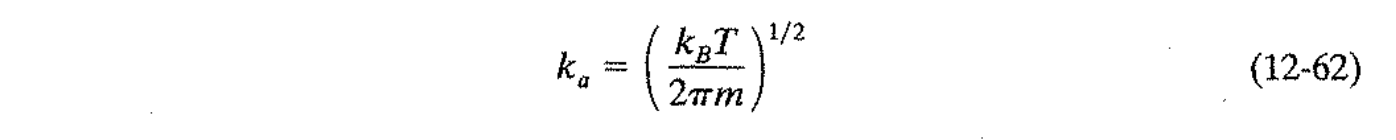

In [4]:
# Sticking rate constant per site
Image(filename='images/Sticking_probability_textbook.png',width = 700, height = 300) 

In [3]:
# Calculate Matlab Value for hydrogen surface dissociation
# H2 + X2 <--> 2HX
##########################################################

stickcoeff = 1 # sticking coeff for hydrogen
mass = 2.01588 # atomic mass h2
mamu = 1.66053886E-27 # kg mass of neutron/proton
kB = 1.3806503E-23    # m2 kg s-2 K-1
T = 483.5             # K 
site_density=2.9e-09*(100**2)  # (sites/m^2)
Ea = 40.4419 #kj/mol
R = 8.3145 #J/mol/K

# Matlab rate 
kfwdh2 =stickcoeff * 1.0123E6 *((2*np.pi*mass*mamu*1000*kB*(10**7)*T)**(-0.5))*1.0E-15;
kfwdh2 = kfwdh2 * np.exp(-Ea*1e3/R/T)

print('catalyst sites [mol/kg]', cat_site_per_wt)
print("k_fwd calculated using matlab equation: {:.2e}".format(kfwdh2))

# Calculate cantera rate for hydrogen surface dissociation
# H2 + X2 <--> 2HX
##########################################################
a = 1
b = 0
c = 40.4419*1e6  # activation energy from Grabow matlab, [J/kmol]
R = 8.3145e3       # J/kmol/K
W = 2.016     # kg/kmol
little_gamma = a*T**b*math.exp(-c/(R*T))
print(f"little gamma (sticking coeff) = {little_gamma:.2e}")
big_gamma = 2.9e-09*(100**2)*1e-3 #2.9e-9 moles/cm^2  now in kmol/m2
m = 2 # h2 + 2X, m = sum of surface site stoich coeffs
print(f"big gamma (surface site density) {big_gamma} kmol/m2")
kf = (little_gamma/big_gamma**m) * math.sqrt(R*T/(2*np.pi*W))
print("Calculated using Sticking coeff {:.2e} m5/kmol2/s".format(kf))
print("cantera value {:.2e}  m5/kmol2/s".format(surf.forward_rate_constants[1]))

# convert Matlab rate to cantera
kfwd_convert = kfwdh2*(site_density/R*T)
print(f'{kfwd_convert} [m5/kmol2/s]')

catalyst sites [mol/kg] 0.3
k_fwd calculated using matlab equation: 3.65e+04
little gamma (sticking coeff) = 4.28e-05
big gamma (surface site density) 2.9e-08 kmol/m2
Calculated using Sticking coeff 2.86e+13 m5/kmol2/s
cantera value 6.70e+17  m5/kmol2/s
0.06159828338085636 [m5/kmol2/s]


In [7]:
# print rates
def report_rate_constants(n=8):
#     print("\nHighest forward rate constants, gas")
#     for i in np.argsort(abs(gas.forward_rate_constants))[-1:-n:-1]: # top n in descending order
#         print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rate_constants[i]:8.1e}")
    print("\nHighest forward rate constants, surface")
    for i in np.argsort(abs(surf.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {surf.reaction_equation(i):48s}  {surf.forward_rate_constants[i]:8.1e}")
#         print(surf.reaction(i).is_sticking_coefficient)
#     print("\nHighest reverse rate constants, gas")
#     for i in np.argsort(abs(gas.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
#         print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, surface")
    for i in np.argsort(abs(surf.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {surf.reaction_equation(i):48s}  {surf.reverse_rate_constants[i]:8.1e}")

    print("Units are a combination of kmol, m^3 and s, that depend on the rate expression for the reaction.")

report_rate_constants(20)


Highest forward rate constants, surface
 39 : HCOX + OX <=> COX + OHX                            3.4e+20
 44 : CH2OX + HCOX <=> CH3OX + COX                       3.4e+20
 12 : COOHX + OHX <=> CO2X + H2OX                        3.4e+20
  2 : H2 + 2 X <=> 2 HX                                  6.7e+17
  4 : H2O + X <=> H2OX                                   6.5e+09
  3 : CO + X <=> COX                                     5.2e+09
  6 : CH2O + X <=> CH2OX                                 5.0e+09
  7 : CH3OH + X <=> CH3OHX                               4.9e+09
  1 : CO2 + X <=> CO2X                                   4.2e+09
  5 : HCOOH + X <=> HCOOHX                               4.1e+09
  8 : HCOOCH3 + X <=> HCOOCH3X                           3.6e+09
 16 : 2 OHX <=> H2OX + OX                                0.0e+00
 21 : H2CO2X + HX <=> CH3O2X + X                         0.0e+00
 20 : HCOOHX + HX <=> CH3O2X + X                         0.0e+00
 19 : HCOOX + HX <=> HCOOHX + X                  

### Rate calculation

below is an attempt to run H2 through the matlab rate calculations. The inlet and outlet is pressure is in (atm). The conditions used are Graaf1998_ExptID_1.mat

In [8]:
import scipy.io
# I will probably turn this section into a function so I can process all files
mat = scipy.io.loadmat('Matlab_files/Graaf1988_ExpID_1.mat')
conditions = mat['ccondition']
reactions = mat['reaction']

In [9]:
# load array of partial pressures. load species table to steal header line from that.
partial_press = mat['Y']
Species_prop = mat['species']

In [10]:
# load reactions to dataframe 
reactions_df = pd.DataFrame(data = reactions[0])

In [11]:
# Extract species names, remove unnecessary characters from column headers
species_names = []
translation = {39: None, 91: None, 93: None} # remove ', [, and ]

for spec in range(len(Species_prop[0,:])):
    species_string = str(Species_prop[0,spec][0])
    species_string = species_string.translate(translation)
    species_names.append(species_string)
    
# create data frame with species names as column headers
species_df = pd.DataFrame(data=partial_press,columns=species_names)

In [12]:
# make species dictionary corresponding to table
species_num = list(range(1,32))
species_dict = {species_num[i]: species_names[i] for i in range(len(species_num))}
print(species_dict)

{1: 'COg', 2: '*', 3: 'CO', 4: 'H2Og', 5: 'H2O', 6: 'H2g', 7: 'H', 8: 'CO2g', 9: 'CO2', 10: 'OH', 11: 'O', 12: 'COOH', 13: 'HCOOH', 14: 'HCO', 15: 'HCO2', 16: 'H2CO2', 17: 'CH3O2', 18: 'HCOH', 19: 'CH2O', 20: 'CH3O', 21: 'CH2OH', 22: 'CH3OH', 23: 'CH2Og', 24: 'CH3OHg', 25: 'HCOOHg', 26: 'COH', 27: 'CO3', 28: 'HCO3', 29: 'HCOOCH3g', 30: 'HCOOCH3', 31: 'CH2OOCH3'}


In [13]:
species_dict[1]

'COg'

In [14]:
# read in forward reaction rate constants 
reaction_string = reactions_df['prettyprnt'][2]
k_fwd = []
k_rev = []

for const in range(len(reactions_df)):
    k_fwd_str = float(reactions_df['kfwd'][const])
    k_rev_str = float(reactions_df['krev'][const])
    k_fwd.append(k_fwd_str)
    k_rev.append(k_rev_str)


In [15]:
# Read in stoichiometry table.
stoich = []
for coef in range(len(reactions_df)):
    stoich.append(reactions_df['stoichiometry'][coef][0])

In [16]:
# read in species array from reaction table. contains species index participating in reaction 
# (e.g [1,2,3] for CO2, *, and CO)
species_reac = []
for spec in range(len(reactions_df)):
    species_reac.append(reactions_df['ispecies'][spec][0])

In [17]:
print(species_dict)

{1: 'COg', 2: '*', 3: 'CO', 4: 'H2Og', 5: 'H2O', 6: 'H2g', 7: 'H', 8: 'CO2g', 9: 'CO2', 10: 'OH', 11: 'O', 12: 'COOH', 13: 'HCOOH', 14: 'HCO', 15: 'HCO2', 16: 'H2CO2', 17: 'CH3O2', 18: 'HCOH', 19: 'CH2O', 20: 'CH3O', 21: 'CH2OH', 22: 'CH3OH', 23: 'CH2Og', 24: 'CH3OHg', 25: 'HCOOHg', 26: 'COH', 27: 'CO3', 28: 'HCO3', 29: 'HCOOCH3g', 30: 'HCOOCH3', 31: 'CH2OOCH3'}


In [20]:
# run through first step of solver and compare resulting pressures/surface fractions. 
Y_step1 = np.zeros(len(partial_press[0]))
rates = np.zeros(len(reactions_df))

for reaction in range(len(reactions_df)):
    reactant = 1
    product = 1

    for coef in range(len(stoich[reaction])):
        if stoich[reaction][coef] < 0:
            reactant*=species_df[species_dict[species_reac[reaction][coef]]][0]**np.absolute(stoich[reaction][coef])
        if stoich[reaction][coef] > 0:
            product*=species_df[species_dict[species_reac[reaction][coef]]][0]**np.absolute(stoich[reaction][coef])     
            
    rates[reaction] = k_fwd[reaction]*reactant+k_rev[reaction]*product
    

    
print(f'{rates[2]} mol/site/sec')

dy_h2 = 8.3145*483/(1.347000000000000e-4)*0.001307404000000*rates[2]/(1.01325*1E5)
print(dy_h2)

yh2_new = species_df['H2g'][0] - dy_h2 
print(species_df['H2g'][0])

371523.87833491334 mol/site/sec
371523.87833491334
142920.85357339375
10.177350111028868


In [19]:
Fin = float(conditions['Fin'])
Fout = float(conditions['Fout'])
print(Fin)
print(Fout)

0.1875915274349931
0.00028418620020959767
